###Gradient Boosted Decision Trees are one of the most powerful and widely used approaches in modern ML. To get additional practice with them on a real-world problem, I downloaded an IBM dataset on customer churn and set up a gradient boosted tree with XGBoost with the goal of predicting if a customer will leave or not. This notebook delineates my approach to the problem.

###1) Import modules

Necesarry installs: pandas, numpy, sklearn, xgboost

Bonus: graphviz for pretty visualizations :)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

### 2) Import data

Let's use a dataset on the Taylor Manifest Anxiety Scale to predict deprssion and anxiety based on responses to a questionaire. You can find the data here https://www.kaggle.com/yeanzc/telco-customer-churn-ibm-dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Telco_customer_churn.csv to Telco_customer_churn.csv


In [ ]:
import io

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['Telco_customer_churn.csv']))
df.shape

(7043, 33)

In [ ]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


###3) Inspecting and preprocessing our data

Since we're trying to develop a model to predict if an employee will leave, we need to remove data with exit interview information. 'Churn Value' gives the ground truth label, so we'll leave that in our dataframe for now and seperate it after we've done some exploratory data analysis.

In [ ]:
df.drop(['Churn Label', 
         'Churn Score',
         'CLTV',
         'Churn Reason'],
        axis=1, inplace=True)

Check for columns that contain only a single value, and remove these since they don't give us any additional predictive power.

In [ ]:
for name in df.columns:
  if len(df[name].unique()) <= 1:
    df.drop([name], axis=1, inplace=True)


Let's check out dataframe now

In [ ]:
print(df.shape)
df.head()

(7043, 26)


,CustomerID,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


Down from 33 to 26 columns, so looks like we removed removed a lot of unnecessary data. However we can also see that we have redundant data from Lat Long, since we already have Latitude and Longitude columns individually. We also still have CustomerID, which is different for every customer and doesn't give us any additional predictive insight. Lets remove that too.

In [ ]:
df.drop(['Lat Long','CustomerID'], axis=1, inplace=True)

Our data has a lot of whitespaces right now for elements in columns 'City', 'Internet Service', etc. Let's quickly remove those and replace them with underscores, and do the same for column headers as well. 

In [ ]:
'''for name in df.columns:
  if type(df[name][0]) is str:
    df[name].replace(' ', '_', regex=True, inplace=True)

df.columns = df.columns.str.replace(' ', '_')'''

"for name in df.columns:\n  if type(df[name][0]) is str:\n    df[name].replace(' ', '_', regex=True, inplace=True)\n\ndf.columns = df.columns.str.replace(' ', '_')"

In [ ]:
df.replace(' ', '_', regex=True, inplace=True)
df.columns = df.columns.str.replace(' ', '_')

Now we need to check for missing and incomplete data. XGBoost is pretty good at dealing with missing data, so we'll just explore for missing data and set the values to 0.

In [ ]:
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.3,1


In [ ]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

Most columns have an object dtype, which we need to change since it is not compatible with XGBoost. Total_Charges also stands out since it looks like it should be a float64 dtype but instead is an object. We can do that conversion manually with pd.to_numeric, which returns float64 or int64 depending on the data.

In [ ]:
#This line gives an error
#df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

Unexpected error, looks like there was an empty value in the Total_Charges data that we converted to an underscore earlier. We should set this to 0 and XGBoost can handle the rest, but should check for more missing values in our data first.

In [ ]:
for name in df.columns:
  num_empty = len(df.loc[df[name] == '_'])
  print('num missing values in col {} is {}'.format(name, num_empty))
  

num missing values in col City is 0
num missing values in col Zip_Code is 0
num missing values in col Latitude is 0
num missing values in col Longitude is 0
num missing values in col Gender is 0
num missing values in col Senior_Citizen is 0
num missing values in col Partner is 0
num missing values in col Dependents is 0
num missing values in col Tenure_Months is 0
num missing values in col Phone_Service is 0
num missing values in col Multiple_Lines is 0
num missing values in col Internet_Service is 0
num missing values in col Online_Security is 0
num missing values in col Online_Backup is 0
num missing values in col Device_Protection is 0
num missing values in col Tech_Support is 0
num missing values in col Streaming_TV is 0
num missing values in col Streaming_Movies is 0
num missing values in col Contract is 0
num missing values in col Paperless_Billing is 0
num missing values in col Payment_Method is 0
num missing values in col Monthly_Charges is 0
num missing values in col Total_Cha

Most of the data looks ok, but there are 11 missing values in Total_Charges. We'll fix this by replacing the missing values with 0, then let XGBoost's built in functinality determine the default behavior, as explained here https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/

In [ ]:
df.loc[df['Total_Charges'] == '_']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,No_phone_service,DSL,Yes,No,Yes,Yes,Yes,No,Two_year,Yes,Bank_transfer_(automatic),52.55,_,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.25,_,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two_year,No,Mailed_check,80.85,_,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.75,_,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,No_phone_service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two_year,No,Credit_card_(automatic),56.05,_,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,19.85,_,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.35,_,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.00,_,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,One_year,Yes,Mailed_check,19.70,_,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two_year,No,Mailed_check,73.35,_,0


All of these have 0 for Tenure_Months. So the reason that Total_Charges has missing values is probably because these people just joined and literally haven't paid anything yet.

In [ ]:
df.loc[(df['Total_Charges'] == '_'), 'Total_Charges'] = 0
len(df.loc[df['Total_Charges'] == 0])

11

In [ ]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

### 4) Encode and split data

All of the missing values have been changed to 0 and we converted Total_Charges to float64. Now we need to do something about the columns with object dtypes, since XGBoost doesn't natively support categorical data.

We need to encode our categorical variable into unique features. One-hot encoding and dummy variables are both fine for a simple problem like this. Instead of typing column headers by hand, we can get our categorical variables by looking for all columns with entries that are string dtypes.

In [ ]:
X = df.drop('Churn_Value', axis=1).copy() 

categorical_vars = []
for name in X:
  if type(df[name][0]) is str:
    categorical_vars.append(name)

X_enc = pd.get_dummies(X, columns = categorical_vars)
X_enc.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso_Viejo,City_Alleghany,City_Alpaugh,City_Alpine,City_Alta,City_Altadena,City_Alturas,City_Alviso,City_Amador_City,City_Amboy,City_Anaheim,City_Anderson,City_Angels_Camp,City_Angelus_Oaks,City_Angwin,City_Annapolis,City_Antelope,City_Antioch,City_Anza,City_Apple_Valley,City_Applegate,...,Senior_Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone_Service_No,Phone_Service_Yes,Multiple_Lines_No,Multiple_Lines_No_phone_service,Multiple_Lines_Yes,Internet_Service_DSL,Internet_Service_Fiber_optic,Internet_Service_No,Online_Security_No,Online_Security_No_internet_service,Online_Security_Yes,Online_Backup_No,Online_Backup_No_internet_service,Online_Backup_Yes,Device_Protection_No,Device_Protection_No_internet_service,Device_Protection_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0


In [ ]:
y = df['Churn_Value'].copy() 
assert(len(y.unique()) == 2) # make sure our prediction is a binary variable

Now we should split our train and test sets. Scikit-learn makes this very simple. Make sure to stratify to keep the same percentage of customers who left in both train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, stratify=y)
assert np.isclose(sum(y_train)/len(y_train), sum(y_test)/len(y_test), rtol=0.01) # always good to double check that stratify worked as intended

### 5) Implement a gradient boosted tree

XGBoost makes building a gradient boosted tree extremely simple. Like most other ML models, the fun part is learning what's going on under the hood. I'd highly recommend reading through some of the following resources if you're looking to learn about how gradient boosted trees work, or just want a refresher
* XGBoost Docs, Intro to Boosted Trees: https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* XGBoost: A Scalable Tree Boosting System: https://arxiv.org/abs/1603.02754
* Greedy function approximation: A gradient boosting machine: https://www.jstor.org/stable/2699986

In [ ]:
model = xgb.XGBClassifier(objective='binary:logistic')
model.fit(X_train, y_train, verbose=True, early_stopping_rounds=10,
          eval_metric='aucpr', eval_set=[(X_test, y_test)])

In [ ]:
xgb_model = xgb.XGBRFRegressor(random_state=42)
xgb_model.fit(X_train, y_train, verbose=True, early_stopping_rounds=10,
          eval_metric='aucpr', eval_set=[(X_test, y_test)])

[23:41:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-aucpr:0.649033
Will train until validation_0-aucpr hasn't improved in 10 rounds.


XGBRFRegressor(random_state=42)

In [ ]:
node_params= {'shape': 'box', 
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}

leaf_params= {'shape': 'box', 
              'style': 'filled, rounded',
              'fillcolor': '#e48038'}

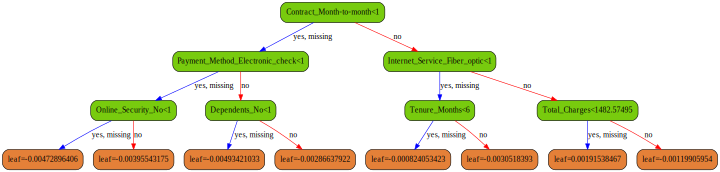

In [ ]:
xgb.to_graphviz(xgb_model, num_trees=0, size='10,10', condition_node_params=node_params, leaf_node_params=leaf_params)

In [ ]:
params = {
  'colsample_bynode': 0.8,
  'learning_rate': 1,
  'max_depth': 5,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.8,
  'tree_method': 'gpu_hist'
}

In [ ]:
bst = train(params, dmatrix, num_boost_round=1)

NameError: ignored

In [ ]:
from sklearn.model_selection import KFold

# Your code ...

kf = KFold(n_splits=2)
for train_index, test_index in kf.split(X_t, y):
    xgb_model = xgb.XGBRFRegressor(random_state=42).fit(
    X[train_index], y[train_index])